---
title: "Advanced Optimization: Newton's Method and Adam"
author: Omar Armbruster
date: '2025-05-05'
image: "images.jfif"
description: "Implementations of the Newton and Adam Optimizers"
format: html
execute:
    message: false
    warning: false
---

# Abstract
In this post we examine Newton's method as an extension of gradient descent as well as the Adam Optimizer. We implement each optimizer and apply them to a logistic regression model to examine their efficacy. We compare Newton's method to standard gradient descent and the Adam Optimizer to stochastic gradient descent on both simulated data and the empirical titanic dataset to evaluate their performances. We then compare Adam and Newton by determining how long it takes each to achieve a loss of $0.5$. We find that Newton's method is much faster than Adam for multiple learning rates. The code for the optimizers can be found [here](https://github.com/omar-armbruster/omar-armbruster.github.io/blob/main/posts/advanced-optimization/optimizers.py).

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import time

c:\Users\omara\.conda\envs\ml451\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2
from optimizers import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer, StochasticGradientDescent

We begin our experiments by defining a function to easily generate two-dimensional data with gaussian noise. This will allow us to test how well our optimizers work before applying them to more complex empirical data.

In [3]:
## Sourced from Phil Chodrow Lecture Notes
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.2)

We also define plotting functions to allow us to visualize the decision regions and loss over numerous iterations of the algorithm. This will allwo us to easily evaluate the efficacy and efficiency of each optimizer.

In [4]:
## Data plotting function sourced from Phil Chodrow Lecture Notes
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "PuOr", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

## Boundary drawing function sourced from Phil Chodrow Lecture Notes
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def plot_loss(loss, ax, **kwargs):
    ax.plot(loss, **kwargs)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')

def plot_results(LR, X, y, loss, ax, **kwargs):
    plot_data(X,y,ax[0])
    draw_line(LR.w, -1, 2, ax[0], color = 'black', **kwargs)
    ax[0].set_title('Decision Boundary')
    ax[1].set_title('Loss')
    plot_loss(loss, ax[1], **kwargs)

# Newton's Method
We first implement Newton's method, which modifies standard gradient descent by multiplying the gradient function by the Hessian matrix, which we compute by $$h_{ij}(\textbf{w}) = \sum_k^2 x_{ki}x_{kj}\sigma(s_k)(1 - \sigma(s_k)).$$ Using this definition we can then update the weights by $$w^{t + 1} = w^t - \alpha H(\textbf{w})^{-1}\nabla L(\textbf{w})$$ where $\alpha$ is the learning rate and $H$ is the Hessian matrix. We can compare this to standard gradient descent by training both for $1000$ iterations with a learning rate of $\alpha = 0.1$. We also add a $w^2$ regularization term, which we scale with parameter `lam`, which we set to $0.01$. It is important here that the regularaization term is less than the learning rate so that the weights are primarily determined by the gradient rather than the regularization.

In [5]:
LR_G = LogisticRegression() 
opt = GradientDescentOptimizer(LR_G)


loss_G = []
for _ in range(1000):
    l = LR_G.loss(X,y, lam = 0.01)
    loss_G.append(l)
    opt.step(X, y, alpha = 0.1, beta = 0, lam = 0.01)

In [6]:
LR_N = LogisticRegression() 
opt = NewtonOptimizer(LR_N)


loss_N = []
for _ in range(1000):
    l = LR_N.loss(X,y, lam = 0.01)
    loss_N.append(l)
    opt.step(X, y, alpha = 0.1, lam = 0.01)

We plot the results for both models and find that both are able to achieve perfect accuracy and very low loss on the linearly separable simulate data. While both optimizers converge to the same loss value, it appears that Newton converges much faster than the standard gradient descent.

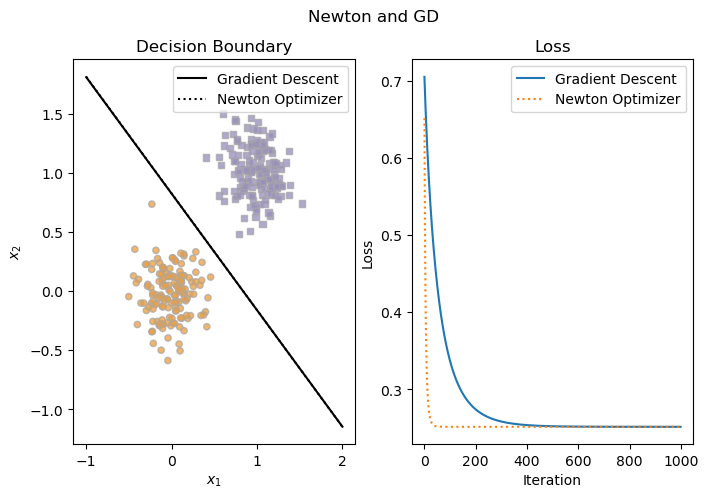

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))
fig.suptitle('Newton and GD')
plot_results(LR_G, X, y, loss_G, ax, label = 'Gradient Descent')
plot_results(LR_N, X, y, loss_N, ax, label = 'Newton Optimizer', ls = ':')
ax[0].legend()
ax[1].legend()

# Newton on Empirical Data

To test the true strength of our Newton optimizer, we apply it to empirical data. For this case we use the Titanic dataset from the `seaborn` package. Our goal is to use the provided features to determine whether or not a given passenger was likely to have survived the sinking of the Titanic. Taking a quick look at the data, we can see features like sex, age, number of siblings/spouses aboard, and the class of ticket the passenger possessed, which each could have some sort of indication on whether a given passenger was more or less likely to survive.

In [8]:
import seaborn as sns
from sklearn.model_selection import train_test_split
empirical_data = sns.load_dataset('titanic')
empirical_data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In order for our logisitic regression model to be able to process the data, we need to convert categorical variables to dummies as well as drop redundant columns and columns that might give away the true label. We also scale the continuous variables using a standard scaling so that all features are considered equally.

In [9]:
e_data = empirical_data.dropna(axis = 0)
y_e = e_data['survived']
e_data = e_data.drop(['survived', 'adult_male', 'alone', 'alive', 'pclass'], axis = 1)
X_e = pd.get_dummies(e_data)
# X_e['ones'] = np.ones_like(y_e)
X_e['age'] = (X_e['age'] - X_e['age'].mean())/X_e['age'].std()
X_e['fare'] = (X_e['fare'] - X_e['fare'].mean())/X_e['fare'].std()
X_e.head()

,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_First,...,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
1,0.151664,1,0,-0.099835,1,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,-0.039765,1,0,-0.337554,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
6,1.172618,0,0,-0.353732,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
10,-2.017864,1,1,-0.813428,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
11,1.427856,0,0,-0.684654,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1


We apply the train-test split, allowing us to validate our models after trianing them.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_e,y_e, test_size=0.3)
X_train = torch.tensor(X_train.to_numpy(), dtype = torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype = torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype = torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype = torch.float32)

Just as with the simulated data, we train our gradient descent and Newton optimizers for $1000$ iterations with a learning rate of $\alpha = 0.1$. 

In [11]:
LR_G = LogisticRegression() 
opt = GradientDescentOptimizer(LR_G)


loss_G = []
for _ in range(1000):
    l = LR_G.loss(X_train,y_train, lam = 0.01)
    loss_G.append(l)
    opt.step(X_train, y_train, alpha = 0.1, beta = 0, lam = 0.01)

In [12]:
LR_N = LogisticRegression() 
opt = NewtonOptimizer(LR_N)


loss_N = []
for _ in range(1000):
    l = LR_N.loss(X_train,y_train, lam = 0.01)
    loss_N.append(l)
    opt.step(X_train, y_train, alpha = 0.1, lam = 0.01)

Because there are more than two features, we cannot plot the decision boundaries. However, we observe a similar trend to the simulated data in the loss, where both converge to a low loss value with Newton's method converging more quickly. This means that with an adequately selected value of $\alpha$, Newton's method can converge to the correct value of $\textbf(w)$ and in some cases, can converge faster than gradient descent.

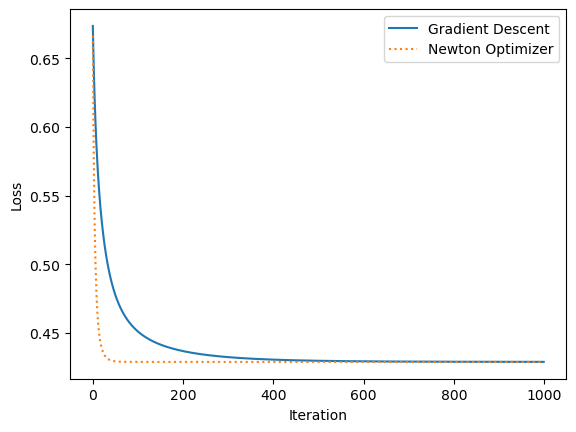

In [13]:
fig, ax = plt.subplots(1,1)
plot_loss(loss_G, ax, label = 'Gradient Descent')
plot_loss(loss_N, ax, label = 'Newton Optimizer', ls = ':')
plt.legend()

We can validate the training of our models and find that both achieve very similar testing losses, indicating that neither model was overfit, even though they converged quite quickly.

In [14]:
print("Gradient Descent Test Loss: {} Newton Test Loss: {}".format(LR_G.loss(X_test, y_test).item(), LR_N.loss(X_test, y_test).item()))

Gradient Descent Test Loss: 0.46767881512641907 Newton Test Loss: 0.46853649616241455


We can also test the case where $\alpha$ is selected to be too high, in which we expect Newton's method to fail. We train our two models as we did in the previous experiments.

In [35]:
LR_G = LogisticRegression() 
opt = GradientDescentOptimizer(LR_G)


loss_G = []
for _ in range(100):
    l = LR_G.loss(X_train,y_train, lam = 0)
    loss_G.append(l)
    opt.step(X_train, y_train, alpha = 3.5, beta = 0, lam = 0)

LR_N = LogisticRegression() 
opt = NewtonOptimizer(LR_N)


loss_N = []
for _ in range(100):
    l = LR_N.loss(X_train,y_train, lam = 0)
    # print(LR_N.w)
    # print(LR_N.score(X_train))
    loss_N.append(l)
    opt.step(X_train, y_train, alpha = 3.5, lam = 0)

When we plot the loss, we find that standard gradient decent is still able to converge (although much slower) while Newton's method does not converge at all, oscillating between high loss values near the starting loss. This means that while Newton's method can be quite powerful, it is also fallabile and some cases.

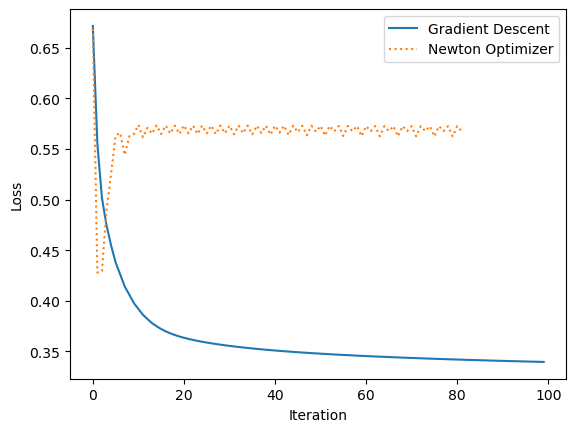

In [36]:
fig, ax = plt.subplots(1,1)
plot_loss(loss_G, ax, label = 'Gradient Descent')
plot_loss(loss_N, ax, label = 'Newton Optimizer', ls = ':')
plt.legend()

# Adam Optimizer
We also implement the Adam Optimizer, a common optimizer used in deep learning models, behaving very similarly to stochastic gradient descent (SGD). The Adam Optimizer randomly selects batches whose size are determined by the `batch_size` parameter and then updates the weights such that $$w^{t + 1} = w^t - \alpha \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}$$ where $\hat{m}$ and $\hat{v}$ are variables based on the gradient that change with time (the number of iterations) and constants $\beta_1$ and $\beta_2$. This time dependent behavior means the step size will decrease with each iteration, allowing for a more precise convergence on the optimal weights near the last few iterations. We train our models with the Adam and SGD optimizers using a learning rate of $\alpha = 0.01$. In order to fine tune our models, we use a very small regularization term for Adam and no regularization for SGD.

In [17]:
LR_A = LogisticRegression() 
opt = AdamOptimizer(LR_A, 10, 0.01, 0.9, 0.999)


loss_A = []
for _ in range(1000):
    l = LR_A.loss(X,y, lam = 0.0001)
    loss_A.append(l)
    # print(LR_A.w)
    opt.step(X, y, lam = 0.0001)

LR_SG = LogisticRegression() 
opt =StochasticGradientDescent(LR_SG, 10, alpha = 0.01)


loss_SG = []
for _ in range(1000):
    l = LR_SG.loss(X,y, lam = 0)
    loss_SG.append(l)
    opt.step(X, y, lam = 0)

When we plot the fit of these two optimizers, we find that both are able to achieve comparable decision boundaries and final losses, but with Adam converging more quickly than the standard SGD.

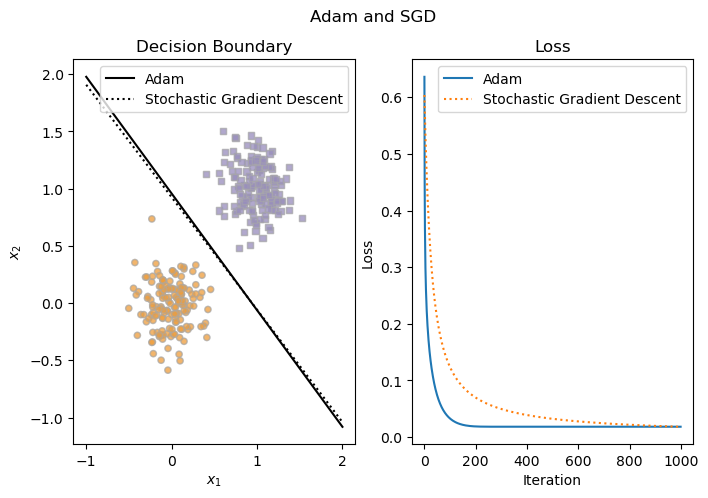

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))
fig.suptitle('Adam and SGD')
plot_results(LR_A, X, y, loss_A, ax, label = 'Adam')
plot_results(LR_SG, X, y, loss_SG, ax, label = 'Stochastic Gradient Descent', ls = ':')
ax[0].legend()
ax[1].legend()

We compare these two optimizers on the Titanic data as well for three values of $\alpha$. For $\alpha = 0.001$, we find that both begin to converge (although do not fully converge after $1000$ iterations) but the SGD converges at a slower rate than the Adam optimizer.

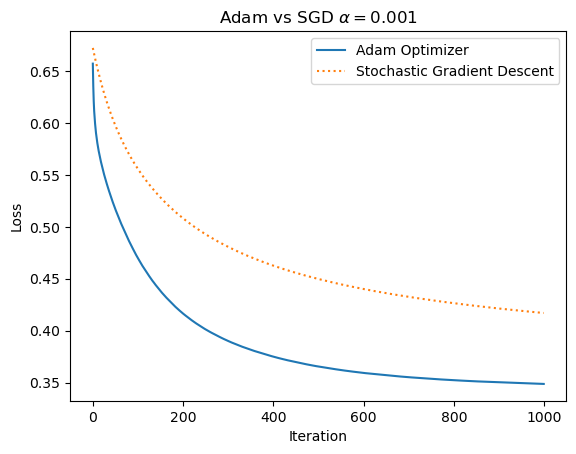

In [19]:
LR_A = LogisticRegression() 
opt = AdamOptimizer(LR_A, 10, 0.001, 0.9, 0.999)


loss_A = []
for _ in range(1000):
    l = LR_A.loss(X_train,y_train, lam = 0.0001)
    loss_A.append(l)
    # print(LR_A.w)
    opt.step(X_train, y_train, lam = 0.0001)

LR_SG = LogisticRegression() 
opt =StochasticGradientDescent(LR_SG, 10, alpha = 0.001)


loss_SG = []
for _ in range(1000):
    l = LR_SG.loss(X_train,y_train, lam = 0.0001)
    loss_SG.append(l)
    opt.step(X_train, y_train, lam = 0.0001)

fig, ax = plt.subplots(1,1)
ax.set_title(r'Adam vs SGD $\alpha = 0.001$')
plot_loss(loss_A, ax, label = 'Adam Optimizer')
plot_loss(loss_SG, ax, label = 'Stochastic Gradient Descent', ls = ':')
plt.legend()

With a higher learning rate of $\alpha = 0.01$, we observe a similar convergance but in much fewer iterations as the steps towards the optimal weights at each step will be larger.

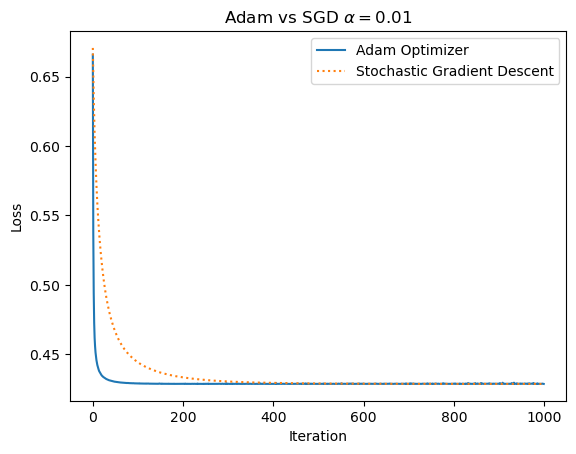

In [20]:
LR_A = LogisticRegression() 
opt = AdamOptimizer(LR_A, 10, 0.01, 0.9, 0.999)


loss_A = []
for _ in range(1000):
    l = LR_A.loss(X_train,y_train, lam = 0.01)
    loss_A.append(l)
    # print(LR_A.w)
    opt.step(X_train, y_train, lam = 0.01)

LR_SG = LogisticRegression() 
opt =StochasticGradientDescent(LR_SG, 10, alpha = 0.01)


loss_SG = []
for _ in range(1000):
    l = LR_SG.loss(X_train,y_train, lam = 0.01)
    loss_SG.append(l)
    opt.step(X_train, y_train, lam = 0.01)

fig, ax = plt.subplots(1,1)
ax.set_title(r'Adam vs SGD $\alpha = 0.01$')
plot_loss(loss_A, ax, label = 'Adam Optimizer')
plot_loss(loss_SG, ax, label = 'Stochastic Gradient Descent', ls = ':')
plt.legend()

When we use $\alpha = 0.1$ for the two optimizers, we find that Adam still converges faster but appears to converge at a higher loss value than SGD. Like Newton, speed appears to come at the expense of accuracy when $\alpha$ is too large, meaning we need to be more cognicant of the learning rate we choose when using these more powerful optimizers.

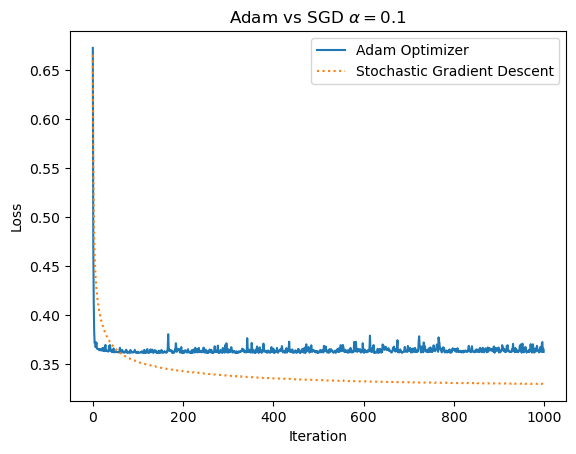

In [21]:
LR_A = LogisticRegression() 
opt = AdamOptimizer(LR_A, 10, 0.1, 0.9, 0.999)


loss_A = []
for _ in range(1000):
    l = LR_A.loss(X_train,y_train, lam = 0.001)
    loss_A.append(l)
    # print(LR_A.w)
    opt.step(X_train, y_train, lam = 0.001)

LR_SG = LogisticRegression() 
opt =StochasticGradientDescent(LR_SG, 10, alpha = 0.1)


loss_SG = []
for _ in range(1000):
    l = LR_SG.loss(X_train,y_train, lam = 0.0)
    loss_SG.append(l)
    opt.step(X_train, y_train, lam = 0.0)

fig, ax = plt.subplots(1,1)
ax.set_title(r'Adam vs SGD $\alpha = 0.1$')
plot_loss(loss_A, ax, label = 'Adam Optimizer')
plot_loss(loss_SG, ax, label = 'Stochastic Gradient Descent', ls = ':')
plt.legend()

# Newton vs Adam
Lastly we want to compare our two implemented optimizers. Becuase the computations are so different between the two methods, we want to measure the different in time to achieve a loss value rather than the number of iterations. We can test this for multiple values of $\alpha$ by determining the amount of time it takes to achieve a loss of $0.5$ or hit $1000$ iterations (to avoid an infinite loop). We print the times for each below and find that at lower values of $\alpha$, Adam appears to be faster. However, as $\alpha$ increases, the times become closer and closer before Newton becomes the faster optimizer at $\alpha = 1$. Based on the times below, Adam is fastest at $\alpha = 0.1$, taking $0.008$ seconds to converge. However, from our previous experiment, we know that when $\alpha = 0.1$, Adam converges at a fairly high loss value. This means that there is some tradeoff between speed and accuracy to consider when choosing the optimal learning rate.

In [22]:
alphas = [0.001, 0.01, 0.1, 1]

for alpha in alphas:
    print('--------alpha = {}--------'.format(alpha))


    LR_A = LogisticRegression() 
    opt = AdamOptimizer(LR_A, 10, alpha, 0.9, 0.999)

    
    loss_A = []
    l = LR_A.loss(X_train,y_train)
    count = 0
    start = time.time()
    while l > 0.5 and count < 1000:
        l = LR_A.loss(X_train,y_train)
        loss_A.append(l)
        # print(LR_A.w)
        opt.step(X_train, y_train, lam = alpha/10)
        count += 1
    end = time.time()
    print('Adam Optimizer Time: {}'.format(end - start))

    LR_N = LogisticRegression() 
    opt = NewtonOptimizer(LR_N)

    loss_N = []
    l = LR_N.loss(X_train,y_train)
    count = 0
    start = time.time()
    while l > 0.5 and count < 1000:
        l = LR_N.loss(X_train,y_train)
        loss_N.append(l)
        opt.step(X_train, y_train, alpha = alpha/10)
        count += 1
    end = time.time()
    print('Newton Optimizer Time: {}'.format(end - start))

--------alpha = 0.001--------
Adam Optimizer Time: 0.2750883102416992
Newton Optimizer Time: 0.7343175411224365
--------alpha = 0.01--------
Adam Optimizer Time: 0.018273591995239258
Newton Optimizer Time: 0.32607245445251465
--------alpha = 0.1--------
Adam Optimizer Time: 0.008029460906982422
Newton Optimizer Time: 0.030339717864990234
--------alpha = 1--------
Adam Optimizer Time: 0.040769338607788086
Newton Optimizer Time: 0.0


# Discussion
This post examined the implementations of the Newton and Adam optimizers and analyzed how they comapared to their simpler gradient descent and stochastic gradient descent counterparts. We found that in most cases, the more advanced optimizers converged faster than the simpler versions. However, in the case of high learning rates, the simpler versions presented more durability, as Newton would oscillate at a high loss value and not converge at all, while Adam would converge but at a much higher loss value than SGD. We tested these observations on both simulated linearly separable data as well as empirical data on the Titanic dataset. Lastly, we compared the two advanced optimizers by comparing the speed at which they achieved a loss of $0.5$. The faster optimizer was largely dependent on the learning rate. However, because we were testing convergance to a fairly high loss value, we need to consider accuracy as well as speed when choosing the optimal optimizer and learning rate combination. Based on this post, we can conclude that both optimizers have their own strengths and weaknesses which can be used to fit the varying needs od different datasets.